In [1]:
import numpy as np 
import random

In [4]:
with open('./data/vocab.txt', 'r',encoding="utf8") as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
   # print(vocab)
with open('./data/vectors.txt', 'r',encoding="utf8") as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]


vocab_size = len(words)
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

In [5]:
from numpy import dot
from numpy.linalg import norm
cos_sim = lambda a, b: dot(a, b)/(norm(a)*norm(b))

In [6]:
a = words[random.randint(0,len(words))]
b = words[random.randint(0,len(words))]
print(a,b)

o2o lê_thống_nhất


In [7]:
dist = {}
for item in words:
    dist[item] = cos_sim(vectors[b],vectors[item])
sorted(dist.items(), key=lambda x: x[1],reverse=True)[:10]

[('lê_thống_nhất', 0.9999999999999998),
 ('nguyễn_thành_nhân', 0.6520938354965224),
 ('lê_nguyên_phương', 0.5983226526901934),
 ('trần_ngọc_hiếu', 0.5877212131825099),
 ('wyedean', 0.5804330022407962),
 ('tuấn_thăng', 0.5760451885124674),
 ('bùi_chí_trung', 0.5751163923676395),
 ('nguyễn_gia_bình', 0.5679530324364702),
 ('hayes', 0.5583416829550395),
 ('amee', 0.5568727537695647)]

In [12]:
import glob 
import json
import random
import json
import random
import os
import glob
from random import randint 
from gensim import corpora, matutils
import pickle as cPickle   
from pyvi import ViTokenizer 
from tqdm import trange, tqdm_notebook
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

# tạo class đọc file 
class FileReader(object):
    def __init__(self, file_path, encoder = None):
        self.file_path = file_path
        self.encoder = encoder if encoder != None else 'utf-16le'

    def read(self):
        with open(self.file_path,'rb') as f:
            s = f.read() 
        return s

    def content(self):
        s = self.read() 
        return s.decode(self.encoder)

    def read_json(self):
        with open(self.file_path) as f:
            s = json.load(f)
        return s
        
    def read_stopwords(self):
        with open(self.file_path, 'r') as f:
            stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
        return stopwords

    def load_dictionary(self):
        return corpora.Dictionary.load_from_text(self.file_path)


In [10]:

class FileStore(object):
    def __init__(self, file_path, data = None):
        self.file_path = file_path
        self.data = data

    def store_json(self):
        print("Save: ",self.file_path)
        with open(self.file_path, 'w') as outfile:
            json.dump(self.data, outfile)

    # store dictionary: https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
    # dict_word là mãng chữa các đoạn text đã được segmentation [[cá, con, ăn],[con, mèo],[con, chó, chạy, qua]]
    # len của dictionary sẽ là 7 
    # no_above là tần suất xuất hiện trên số phần trăm ví dụ: no_above = 0.5 là tần suất xuất hiện không được trên (phải dưới) của tổng số tài liệu 50%
    # no_below là số lần xuất hiện không được dưới ... ví dụ no_below = 2 là số lần xuất hiện trong từng tài liệu không được dưới 2
    def store_dictionary(self, dict_words):
        dictionary = corpora.Dictionary(dict_words)
        dictionary.filter_extremes(no_below=170, no_above=0.3) 
        dictionary.save_as_text(self.file_path)
 

    def save_pickle(self,  obj):
        outfile = open(self.file_path, 'wb')
        fastPickler = cPickle.Pickler(outfile, 4)
        fastPickler.fast = 1
        fastPickler.dump(obj)
        outfile.close()

In [15]:
DATA_TRAIN_JSON = './dataset/train.json'

STOP_WORDS = './data/stopwords-nlp-vi.txt'
SPECIAL_CHARACTER = '0123456789%@$.,=+-!;/()*"&^:#|\n\t\''
DICTIONARY_PATH = '/content/drive/My Drive/NLP/nlp_me/dictionary.txt'

In [16]:
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train_raw = train_loader.read_json()
print('Total data train: %d' %len(data_train_raw))
random.shuffle(data_train_raw)

Total data train: 105800


In [17]:
dic = dict() 
dic_count = dict()
NUM_RANDOM = random.randint(2000,2500) 
for item in data_train_raw:
    if item['category'] not in dic.keys():
        dic[item['category']] = NUM_RANDOM
        dic_count[item['category']] = 0
    if len(dic.keys()) > 10:
        break

In [18]:
data_train = []
data_validate = []
for item in data_train_raw:  
    try:
        if dic[item['category']] > dic_count[item['category']]:
            data_train.append(item)
            dic_count[item['category']]+=1
        if dic[item['category']] < dic_count[item['category']]:
            data_validate.append(item) 
    except:
        continue

In [19]:
# xây dựng class NLP extends từ pyvi để extract feature 
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        self.__set_stopwords()

    #đọc file stop_word đã chứa sẵn trong đường dẫn
    def __set_stopwords(self):
        self.stopwords = FileReader(STOP_WORDS).read_stopwords()

    # vì trong câu sẽ xuất hiện rất nhiều từ vô nghĩa, sẽ làm noise dữ liệu cho nên phải segmentation trước khi train. Sử dụng ViTokenizer từ Pyvi 
    # để tokenize (đây là một model do người việt đã làm để segmentation tiếng việt)
    def segmentation(self):
        return ViTokenizer.tokenize(self.text)

    # loại bỏ kí tự đặc biệt, lowercase và segmentation tiếng việt
    def split_words(self):
        text = self.segmentation()
        try:
            return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
        except TypeError:
            return []

    # get feature trong câu gồm hai bước 
    # loại bỏ kí tự đặc biệt và loại bỏ stop_words - stop_word là những từ vô nghĩa không mang lại hiệu quả train 
    def get_words_feature(self):
        split_words = self.split_words()
        return [word for word in split_words if word.encode('utf-8') not in self.stopwords]


In [23]:
# extract feature 
# build dictionary để chuyển embedding dữ liệu, chuyển về word2vec => bag of word
from past.builtins import xrange
class FeatureExtraction(object):
    def __init__(self, data=None, build_dic=False):
        self.data = data
        self.build_dic = build_dic

    # build từ điển gồm các từ xuất hiện trong văn bản sau khi đã preprocess dữ liệu 
    def __build_dictionary(self):
        print('Building dictionary')
        dict_words = []  
        for i in tqdm_notebook(xrange(len(self.data)), desc='build dictionary'): 
            if self.data[i]['category'].split('.')[0] != 'My': 
                words = NLP(text = self.data[i]['content']).get_words_feature()
                dict_words.append(words)  
        FileStore(file_path=DICTIONARY_PATH).store_dictionary(dict_words)

    # load từ điển đã xây dựng theo dữ liệu train
    def __load_dictionary(self):
        if os.path.exists(DICTIONARY_PATH) == False or self.build_dic == True: 
            print("Dictionary is not exist")
            self.__build_dictionary() 
            self.build_dic = False
        
        self.dictionary = FileReader(DICTIONARY_PATH).load_dictionary()
    # extract feature từ từ điển đã tạo cùng với label
    # x sẽ là word2vec, y là label
    def __build_dataset(self):
        self.features = []
        self.labels = [] 
        for i in tqdm_notebook(xrange(len(self.data)), desc='build dataset'): 
            # if self.data[i]['category'].split('.')[0] != 'My':
            # for key, value in dic.items():
            #   print(key, value)
            content = self.get_dense(self.data[i]['content'])
            self.features.append(content)
            self.labels.append(self.data[i]['category'])
              # if str(self.data[i]['category'].split('.')[1]) == 'Chinh_tri_doi_ngoai' or str(self.data[i]['category'].split('.')[1]) == 'Chinh_tri_noi_bo':
              #   self.labels.append(str(self.data[i]['category'])+'.Chinh_tri')
              # else:
              #   self.labels.append(str(self.data[i]['category'])+'.'+str(self.data[i]['category'].split('.')[1]))

    # def get_dense(self, text):
    #     self.__load_dictionary()
    #     words = NLP(text).get_words_feature()
    #     # Bag of words
    #     vec = self.dictionary.doc2bow(words)  
    #     dense = list(matutils.corpus2dense([vec], num_terms=len(self.dictionary)).T[0])
    #     return dense

    def get_dense(self, text):
        words = NLP(text).get_words_feature()
        vec = []
        for w in words:
            try:
                vec.append(vectors[w])
            except:
                continue
        return np.sum(vec, axis=0)

    def get_data_and_label(self):
        print("** Start build dataset")
        self.__build_dataset()  
        return self.features, self.labels



In [24]:

features_train, labels_train = FeatureExtraction(data=data_train, build_dic=False).get_data_and_label() 

** Start build dataset


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [25]:
# load data hơi lâu nên để hai biến giữ lại data ban dầu 
# a, b = np.array(features_train),np.array(labels_train) 
x, y = np.array(features_train),np.array(labels_train)
 

In [26]:
from keras.utils import to_categorical

# encode label 
mlb = LabelEncoder() 
k = mlb.fit_transform(y)
# one hot encoding 
y = to_categorical(k)

Using TensorFlow backend.


In [27]:
from sklearn.model_selection import train_test_split
# chia tập train, test theo tỉ lệ 8:2   
(x_train,x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2, random_state=43)
y_train.shape

(18356, 11)

In [28]:
print('Shape features:',"Total document",y_train.shape[0] + y_test.shape[0],"- Size matrix train (size dictionary)",x_train.shape)
print('Train set',y_train.shape[0],'docs') 
print('Test set',y_test.shape[0],'docs') 
print("Shape",x.shape,y.shape)
SIZE_TRAIN = x_train.shape[1]
y_test[0]


Shape features: Total document 22946 - Size matrix train (size dictionary) (18356, 50)
Train set 18356 docs
Test set 4590 docs
Shape (22946, 50) (22946, 11)


array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [29]:
print("- tổng số label:")
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label)) 

- tổng số label:
1. Cuoc_song_muon_mau
2. Giao_duc
3. Khoa_hoc
4. Kinh_doanh
5. Phap_luat
6. Tai_chinh_quoc_te
7. The_thao
8. Thi_truong
9. Tin_tuc
10. Van_hoa
11. Xe


In [30]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential

# xây dựng mạng network
class ModelNLP(object):
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):
    model = Sequential()
    model.add(Dense(700, input_shape=(SIZE_TRAIN,), activation='tanh', kernel_initializer="uniform")) 
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(600))      
    model.add(LeakyReLU(alpha=0.3))  
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(500))      
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2))
    model.add(Dense(400))      
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2))
    model.add(Dense(300))    
    model.add(Dense(num_classes, activation=final_activation))
  
    return model
# !pip install tensorflow==1.14
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

model = ModelNLP.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 700)               35700     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 700)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               420600    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 600)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)              

In [31]:
# training 
H = model.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1)

Train on 18356 samples, validate on 4590 samples
Epoch 1/20
18356/18356 [==============================] - 13s 687us/step - loss: 0.3068 - accuracy: 0.9090 - val_loss: 0.2770 - val_accuracy: 0.9091
Epoch 2/20
18356/18356 [==============================] - 12s 647us/step - loss: 0.2819 - accuracy: 0.9091 - val_loss: 0.2556 - val_accuracy: 0.9091
Epoch 3/20
18356/18356 [==============================] - 12s 670us/step - loss: 0.2633 - accuracy: 0.9101 - val_loss: 0.2366 - val_accuracy: 0.9116
Epoch 4/20
18356/18356 [==============================] - 12s 668us/step - loss: 0.2464 - accuracy: 0.9122 - val_loss: 0.2185 - val_accuracy: 0.9147
Epoch 5/20
18356/18356 [==============================] - 12s 652us/step - loss: 0.2308 - accuracy: 0.9158 - val_loss: 0.2017 - val_accuracy: 0.9197
Epoch 6/20
18356/18356 [==============================] - 12s 630us/step - loss: 0.2160 - accuracy: 0.9195 - val_loss: 0.1868 - val_accuracy: 0.9241
Epoch 7/20
18356/18356 [==============================] -

In [32]:
# evaluate 
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

Test Accuracy: 95.474356


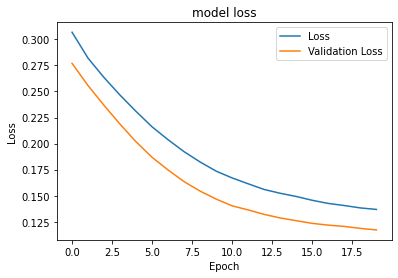

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [45]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/lb_glove_nn.pkl"
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/estimator_glove_nn.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model, ESTIMATE_PATH) 

In [39]:
x_test.shape[0]

4590

In [40]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report
class LSTMModel(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(100))
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_lstm = LSTMModel.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model_lstm.summary() 
 


In [41]:
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],n_features))
H = model_lstm.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1, batch_size=512)

Train on 18356 samples, validate on 4590 samples
Epoch 1/20
18356/18356 [==============================] - 38s 2ms/step - loss: 0.2706 - accuracy: 0.9120 - val_loss: 0.2325 - val_accuracy: 0.9205
Epoch 2/20
18356/18356 [==============================] - 37s 2ms/step - loss: 0.2315 - accuracy: 0.9213 - val_loss: 0.1948 - val_accuracy: 0.9284
Epoch 3/20
18356/18356 [==============================] - 37s 2ms/step - loss: 0.2086 - accuracy: 0.9266 - val_loss: 0.1745 - val_accuracy: 0.9327
Epoch 4/20
18356/18356 [==============================] - 37s 2ms/step - loss: 0.1952 - accuracy: 0.9303 - val_loss: 0.1607 - val_accuracy: 0.9378
Epoch 5/20
18356/18356 [==============================] - 37s 2ms/step - loss: 0.1867 - accuracy: 0.9338 - val_loss: 0.1529 - val_accuracy: 0.9412
Epoch 6/20
18356/18356 [==============================] - 37s 2ms/step - loss: 0.1812 - accuracy: 0.9354 - val_loss: 0.1455 - val_accuracy: 0.9434
Epoch 7/20
18356/18356 [==============================] - 37s 2ms/ste

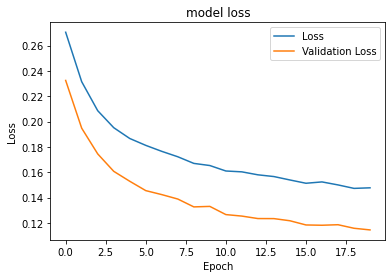

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [43]:
# evaluate 
loss, acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

Test Accuracy: 95.670432


In [46]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/lb_glove_lstm.pkl"
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/estimator_glove_lstm.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_lstm)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_lstm, ESTIMATE_PATH) 

In [47]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU,Conv1D,MaxPooling1D
from sklearn.metrics import classification_report
class CNN_LSTM_Model(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(200))
    model.add(Dense(100))
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_cnnlstm = CNN_LSTM_Model.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_cnnlstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model_lstm.summary() 
  

In [48]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],n_featurimport matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')es))
H = model_cnnlstm.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1, batch_size=512)

Train on 18356 samples, validate on 4590 samples
Epoch 1/20
18356/18356 [==============================] - 20s 1ms/step - loss: 0.2039 - accuracy: 0.9268 - val_loss: 0.1548 - val_accuracy: 0.9412
Epoch 2/20
18356/18356 [==============================] - 19s 1ms/step - loss: 0.1382 - accuracy: 0.9475 - val_loss: 0.1340 - val_accuracy: 0.9484
Epoch 3/20
18356/18356 [==============================] - 19s 1ms/step - loss: 0.1219 - accuracy: 0.9530 - val_loss: 0.1236 - val_accuracy: 0.9527
Epoch 4/20
18356/18356 [==============================] - 20s 1ms/step - loss: 0.1145 - accuracy: 0.9560 - val_loss: 0.1167 - val_accuracy: 0.9560
Epoch 5/20
18356/18356 [==============================] - 19s 1ms/step - loss: 0.1092 - accuracy: 0.9581 - val_loss: 0.1164 - val_accuracy: 0.9552
Epoch 6/20
18356/18356 [==============================] - 20s 1ms/step - loss: 0.1046 - accuracy: 0.9595 - val_loss: 0.1114 - val_accuracy: 0.9575
Epoch 7/20
18356/18356 [==============================] - 20s 1ms/ste

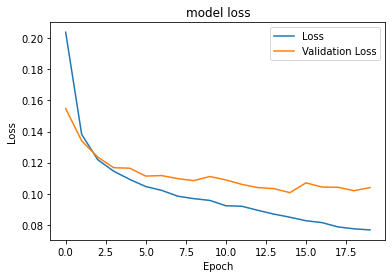

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [50]:
# evaluate 
loss, acc = model_cnnlstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

# lb: label encodem 
# ft: fast text 
# sg: skip gram 
# cnn: convolution neural network 
# lstm: long short term memory 
# nn: neural network

Test Accuracy: 96.149749


In [51]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/lb_glove_cnn_lstm.pkl" 
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/estimator_glove_cnn_lstm.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_cnnlstm)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_cnnlstm, ESTIMATE_PATH) 

In [52]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU,Conv1D,MaxPooling1D,Bidirectional
from sklearn.metrics import classification_report
class RNN_Model(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='tanh', dropout=0.2, recurrent_dropout=0.2))) 
    model.add(Dense(100))
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_rnn = RNN_Model.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model_lstm.summary() 
  

In [53]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],n_features))
H = model_rnn.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1, batch_size=512)

Train on 18356 samples, validate on 4590 samples
Epoch 1/20
18356/18356 [==============================] - 66s 4ms/step - loss: 0.2577 - accuracy: 0.9151 - val_loss: 0.2083 - val_accuracy: 0.9252
Epoch 2/20
18356/18356 [==============================] - 65s 4ms/step - loss: 0.2049 - accuracy: 0.9271 - val_loss: 0.1665 - val_accuracy: 0.9380
Epoch 3/20
18356/18356 [==============================] - 65s 4ms/step - loss: 0.1772 - accuracy: 0.9356 - val_loss: 0.1450 - val_accuracy: 0.9455
Epoch 4/20
18356/18356 [==============================] - 66s 4ms/step - loss: 0.1620 - accuracy: 0.9403 - val_loss: 0.1353 - val_accuracy: 0.9484
Epoch 5/20
18356/18356 [==============================] - 66s 4ms/step - loss: 0.1530 - accuracy: 0.9431 - val_loss: 0.1255 - val_accuracy: 0.9513
Epoch 6/20
18356/18356 [==============================] - 68s 4ms/step - loss: 0.1449 - accuracy: 0.9462 - val_loss: 0.1241 - val_accuracy: 0.9534
Epoch 7/20
18356/18356 [==============================] - 65s 4ms/ste

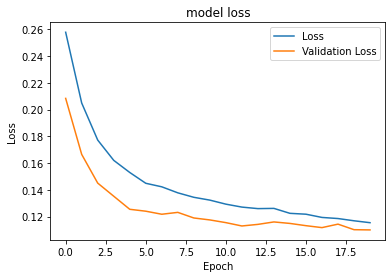

<Figure size 432x288 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [55]:
# evaluate 
loss, acc = model_rnn.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

# lb: label encodem 
# ft: fast text 
# sg: skip gram 
# cnn: convolution neural network 
# lstm: long short term memory 
# nn: neural network

Test Accuracy: 95.850682


In [56]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/lb_glove_rnn.pkl" 
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Glove/estimator_glove_rnn.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_rnn)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_rnn, ESTIMATE_PATH) 